## Imports

In [1]:
import numpy as np
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from itertools import product
import configparser
from dataclasses import dataclass
from typing import Iterator, Sequence, Callable
from matplotlib import pyplot as plt
from shapely import Polygon, Point
import shapely as spl
from bbtoolkit.data import Copyable
from bbtoolkit.data.configparser import EvalConfigParser
from shapely.validation import explain_validity
import shapely.prepared as splp
from scipy.spatial import distance
from bbtoolkit.data import WritablePickle


In [2]:
@dataclass
class Texture(Copyable):
    """
    A data class to represent a Texture.

    Attributes:
        id_ (int): The unique identifier for the texture. Default is -1.
        color (str): The color of the texture. Default is None.
        name (str): The name of the texture. Default is None.
    """
    id_: int = -1
    color: str = None
    name: str = None

    def __post_init__(self):
        """
        Post-initialization method to validate the id_ attribute.

        Raises:
            ValueError: if id_ is 0.
        """
        if self.id_ == 0:
            raise ValueError('Texture ID cannot be 0.')


from typing import Any


class Proxy:
    """
    A class that acts as a proxy for another object, allowing controlled access to its attributes.

    Attributes:
        obj (Any): The object being proxied.
    """
    def __init__(self, obj: Any, **kwargs):
        """
        Initializes the Proxy with the object and any additional attributes.

        Args:
            obj (Any): The object to be proxied.
            **kwargs: Additional attributes to be set on the Proxy.
        """
        self.__scope = list(kwargs.keys()) + [
            '__dict__',
            '__class__',
            '__setattr__',
            '__getattribute__',
            '__getattr__',
            'obj',
            'collect_magic',
            '_Proxy__scope'
        ]
        self.obj = obj

        for key, value in kwargs.items():
            self.__setattr__(key, value)

    def collect_magic(self):
        """
        Collects all magic methods from the proxied object that are not in the scope of the Proxy.

        Returns:
            dict: A dictionary of all the collected magic methods.
        """
        attributes = dir(self.obj)
        __dict__ = dict()
        for attr in attributes:
            if attr.startswith('__') and attr.endswith('__') and attr not in self.__scope:
                __dict__[attr] = getattr(self.obj, attr)
            try:
                __dict__[attr] = getattr(self.obj, attr)
            except:
                raise AttributeError(
                    f'Attribute {attr} cannot be accessed.\n'
                    f'The following error occurred:\n\n{sys.exc_info()[0]}'
                )
        return __dict__

    def __getattr__(self, __name: str) -> Any:
        """
        Overrides the default behavior for attribute access. If the attribute is not in the Proxy's scope,
        it returns the attribute from the proxied object. Otherwise, it returns the attribute from the Proxy.

        Args:
            __name (str): The name of the attribute.

        Returns:
            Any: The value of the attribute.
        """
        if __name not in self.__scope:
            return getattr(self.obj, __name)
        else:
            return self.__dict__[__name]

    def __setattr__(self, __name: str, __value: Any) -> None:
        """
        Overrides the default behavior for setting an attribute. If the attribute is in the Proxy's scope,
        it sets the attribute on the Proxy. Otherwise, it sets the attribute on the proxied object.

        Args:
            __name (str): The name of the attribute.
            __value (Any): The value to set the attribute to.
        """
        if __name == '_Proxy__scope' or __name in self.__scope:
            super().__setattr__(__name, __value)
        else:
            setattr(self.obj, __name, __value)


class TexuredPolygon(Proxy):
    """
    A class representing a textured polygon, inheriting from the Proxy class.

    Attributes:
        shell (Sequence | Polygon): The outer boundary of the polygon or a Polygon instance to transform into TexturedPolygon.
        holes (Sequence[Sequence], optional): The holes within the polygon. Default is None.
        texture (Texture, optional): The texture of the polygon. Default is None.
    """
    def __init__(self, shell: Sequence | Polygon, holes: Sequence[Sequence] = None, texture: Texture = None):
        if not isinstance(shell, Polygon):
            polygon = Polygon(shell, holes)
        elif isinstance(shell, Polygon):
            if holes is not None:
                raise ValueError('Cannot specify holes for a Polygon object.')
            polygon = shell
        else:
            raise ValueError(f'Invalid shell type: {type(shell)}')

        texture = texture if texture is not None else Texture()
        super().__init__(polygon, texture=texture)


def plot_polygon(polygon: TexuredPolygon, ax: plt.Axes = None, **kwargs) -> plt.Figure:
    """
    Plots a given polygon on a matplotlib figure.

    Args:
        polygon (TexuredPolygon): The polygon to be plotted.
        ax (plt.Axes, optional): The axes object to draw the plot onto. If None, a new figure and axes object are created. Defaults to None.
        **kwargs: Arbitrary keyword arguments to be passed to the plot function.

    Returns:
        plt.Figure: The figure object with the plotted polygon.
    """
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    if isinstance(polygon, TexuredPolygon) and polygon.texture.color is not None:
        kwargs.setdefault('color', polygon.texture.color)
    else:
        kwargs.setdefault('color', 'tab:red')

    ax.plot(*polygon.exterior.xy, **kwargs)

    if polygon.interiors:
        for interior in polygon.interiors:
            ax.plot(*interior.xy, **kwargs)

    return fig


class EnvironmentBuilder(Copyable):
    """
    A class for building environments, defining training areas, objects, and creating configurations.

    Attributes:
        xy_min (float): Minimum value for X and Y axes of the environment.
        xy_max (float): Maximum value for X and Y axes of the environment.
        xy_train_min (float | tuple[float, float]): Minimum training area coordinates for X and Y (default is None).
        xy_train_max (float | tuple[float, float]): Maximum training area coordinates for X and Y (default is None).
        res (float): The resolution used for processing geometry data (default is 0.3).

    Methods:
        to_config(self) -> configparser.ConfigParser: Convert the environment configuration to a ConfigParser object.
        save(self, path: str): Save the environment configuration to a file at the specified path.
        load(cls, path: str) -> 'EnvironmentBuilder': Load an environment configuration from a file.
        add_object(self, *args: Object2D) -> 'EnvironmentBuilder': Add objects to the environment.
        plot(self, show: bool = False) -> plt.Figure: Plot the environment.

    Example:
        >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, res=0.5)
        >>> builder.set_textures(5).set_polygons(8)
        >>> builder.add_object(Object2D(x=(0, 1, 1, 0), y=(0, 0, 1, 1)))
        >>> fig = builder.plot(show=True)
    """
    def __init__(
        self,
        xy_min: float,
        xy_max: float,
        xy_train_min: float | tuple[float, float] = None,
        xy_train_max: float | tuple[float, float] = None,
        res: float =  0.3,
    ) -> None:
        # Initialize the EnvironmentBuilder with specified configurations
        self.xy_min = xy_min
        self.xy_max = xy_max

        if xy_train_max is None:
            self.x_train_max, self.y_train_max = self.xy_max, self.xy_max
        elif isinstance(xy_train_max, float):
            self.x_train_max, self.y_train_max = xy_train_max, xy_train_max
        else:
            self.x_train_max, self.y_train_max = xy_train_max
        if xy_train_min is None:
            self.x_train_min, self.y_train_min = self.xy_min, self.xy_min
        elif isinstance(xy_train_min, float):
            self.x_train_min, self.y_train_min = xy_train_min, xy_train_min
        else:
            self.x_train_min, self.y_train_min = xy_train_min

        self.res = res
        self.objects = list()

    def to_config(self) -> configparser.ConfigParser:
        """
        Generate a configuration parser instance containing environmental information.

        Returns:
            configparser.ConfigParser: Configuration parser instance representing the environmental boundaries,
            training area, building boundaries, and object vertices.

        The generated configuration contains sections representing different aspects of the environment:
        - 'ExternalSources': Empty sections for paths and variables.
        - 'GridBoundaries': Contains maximum and minimum XY coordinate and resolution details.
        - 'TrainingRectangle': Describes the training area coordinates.
        - 'BuildingBoundaries': Holds the maximum number of object points, number of objects, and
          counts of polygons and textures in the environment.

        The object-specific information is stored under individual sections 'Object{i}' for each object.
        Each object section contains 'n_vertices' and 'object_x'/'object_y' detailing the object's vertices.
        """
        parser = EvalConfigParser()
        parser.add_section('ExternalSources')
        parser.set('ExternalSources', 'paths', '')
        parser.set('ExternalSources', 'variables', '')

        parser.add_section('GridBoundaries')
        parser.set('GridBoundaries', 'max_xy', str(self.xy_max))
        parser.set('GridBoundaries', 'min_xy', str(self.xy_min))
        parser.set('GridBoundaries', 'res', str(self.res))

        parser.add_section('TrainingRectangle')
        parser.set('TrainingRectangle', 'min_train_x', str(self.x_train_min))
        parser.set('TrainingRectangle', 'min_train_y', str(self.y_train_min))
        parser.set('TrainingRectangle', 'max_train_x', str(self.x_train_max))
        parser.set('TrainingRectangle', 'max_train_y', str(self.y_train_max))

        parser.add_section('BuildingBoundaries')
        parser.set('BuildingBoundaries', 'max_n_obj_points', str(max([len(obj.exterior.xy[0]) for obj in self.objects])))
        parser.set('BuildingBoundaries', 'n_objects', str(len(self.objects)))

        for i, obj in enumerate(self.objects):
            parser.add_section(f'Object{i+1}')
            parser.set(f'Object{i+1}', 'n_vertices', str(len(obj.exterior.xy[0])))
            parser.set(f'Object{i+1}', 'object_x', str(obj.exterior.xy[0].tolist())[1:-1])
            parser.set(f'Object{i+1}', 'object_y', str(obj.exterior.xy[1].tolist())[1:-1])
            parser.set(f'Object{i+1}', 'texture_id', str(obj.texture.id_))
            parser.set(f'Object{i+1}', 'texture_color', str(obj.texture.color))
            parser.set(f'Object{i+1}', 'texture_name', str(obj.texture.name))

        return parser

    def save(self, path: str):
        """
        Save the generated environment configuration to a specified .ini file.

        Args:
            path (str): The file path to which the configuration will be saved.

        This method uses the `to_config` method to generate the environment configuration and then writes
        it to a file specified by the 'path' argument.
        """
        config = self.to_config()

        with open(path, 'w') as f:
            config.write(f)

    @staticmethod
    def load(path: str) -> 'EnvironmentBuilder':
        """
        Load an environment configuration from a specified .ini file and create an `EnvironmentBuilder` instance.

        Args:
            path (str): The file path from which the environment configuration will be loaded.

        This method loads the configuration stored in the file specified by the 'path' argument. The loaded
        configuration includes details of the grid boundaries, training rectangle, objects, and building boundaries.
        It then uses this loaded information to create an `EnvironmentBuilder` instance.

        Returns:
            EnvironmentBuilder: An `EnvironmentBuilder` instance with the loaded environment configuration.

        Example:
            >>> builder = EnvironmentBuilder.load('environment_config.ini')
            >>> # The builder variable now contains an `EnvironmentBuilder` instance with the loaded configuration.
        """
        config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
        config.read(path)
        return EnvironmentBuilder(
            config['GridBoundaries'].eval('min_xy'),
            config['GridBoundaries'].eval('max_xy'),
            (
                config['TrainingRectangle'].eval('min_train_x'),
                config['TrainingRectangle'].eval('min_train_y')
            ),
            (
                config['TrainingRectangle'].eval('max_train_x'),
                config['TrainingRectangle'].eval('max_train_y')
            ),
            config['GridBoundaries'].eval('res')
        ).add_object(
            *[
                TexuredPolygon(
                    (
                        Point(x, y)
                        for x, y in zip(
                            config[f'Object{i}'].eval('object_x'),
                            config[f'Object{i}'].eval('object_y')
                        )
                    ),
                    texture=Texture(
                        config[f'Object{i}'].eval('texture_id'),
                        config[f'Object{i}'].eval('texture_color'),
                        config[f'Object{i}'].eval('texture_name')
                    )
                )
                for i in range(1, config['BuildingBoundaries'].eval('n_objects')+1)
            ]
        )

    def __validate_objects(self, *objects: Polygon | TexuredPolygon) -> None:
        for object_ in objects:
            if not object_.is_valid:
                raise ValueError(f'Object {object_} is not valid: {explain_validity(object_)}')

    def __validate_textures(self, *objects: Polygon | TexuredPolygon) -> list[TexuredPolygon]:
        out = list()
        for obj in objects:
            if isinstance(obj, TexuredPolygon):
                out.append(obj)
            else:
                out.append(TexuredPolygon(obj))

        return out

    def add_object(self, *args: Polygon | TexuredPolygon) -> 'EnvironmentBuilder':
        """
        Add one or multiple Object2D instances to the environment being constructed.

        Args:
            *args (Object2D): Variable number of Object2D instances to be added to the environment.

        This method appends one or more Object2D instances to the list of objects within the environment being built.
        The Object2D instances contain details such as vertices and coordinates of the geometric objects present
        within the environment.

        Returns:
            EnvironmentBuilder: The updated instance of the EnvironmentBuilder with the added objects.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10)  # Create an EnvironmentBuilder instance
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))  # Define an Object2D instance
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))  # Define another Object2D instance

            >>> builder.add_object(obj1, obj2)
            >>> # The builder instance now includes obj1 and obj2 within the list of objects.
        """
        self.__validate_objects(*args)
        self.objects += list(self.__validate_textures(*args))
        return self

    def remove_object(self, i: int) -> 'EnvironmentBuilder':
        """
        Removes the object at the specified index from the list of objects in the environment.

        Args:
            i (int): The index of the object to be removed.

        Returns:
            EnvironmentBuilder: The modified EnvironmentBuilder object after removing the specified object.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> builder = builder.remove_object(0)
            >>> # Object at index 0 has been removed from the EnvironmentBuilder.
        """
        self.objects.pop(i)
        return self

    def __getitem__(self, i: int) -> Polygon:
        """
        Accesses the object at the specified index within the list of objects.

        Args:
            i (int): The index of the object to retrieve.

        Returns:
            Polygon: The object at the specified index in the list of objects.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> retrieved_obj = builder[0]
            >>> # 'retrieved_obj' is now equal to the object at index 0 in the EnvironmentBuilder.
        """
        return self.objects[i]

    def __setitem__(self, i: int, obj: Polygon) -> None:
        """
        Sets the object at the specified index within the list of objects.

        Args:
            i (int): The index of the object to set.
            obj (Polygon): The object to be set at the specified index.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> builder[0] = obj2
            >>> # Object at index 0 has been replaced with obj2.
        """
        self.__validate_objects(obj)
        self.objects[i] = self.__validate_textures(obj)[0]

    def __len__(self) -> int:
        """
        Returns the number of objects currently stored in the environment.

        Returns:
            int: The number of objects in the environment.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> obj_count = len(builder)
            >>> # 'obj_count' is now equal to the number of objects stored in the EnvironmentBuilder.
        """
        return len(self.objects)

    def __iter__(self) -> Iterator[Polygon]:
        """
        Provides an iterator over the objects in the environment.

        Returns:
            Iterator[Object2D]: An iterator over the objects in the environment.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> for obj in builder:
            >>>     print(obj)
            >>> # Iterates through each object in the EnvironmentBuilder and prints them.
        """
        return iter(self.objects)

    def __add__(self, other: 'EnvironmentBuilder') -> 'EnvironmentBuilder':
        """
        Adds the objects and properties of two EnvironmentBuilder instances.

        Merges the objects from two separate EnvironmentBuilder instances into a new instance.
        The new instance retains the original attributes of the first instance (self), such as grid boundaries,
        training rectangle, resolution, and objects. It also appends the objects and updates the properties (textures
        and polygons) as specified.

        Args:
            other (EnvironmentBuilder): Another EnvironmentBuilder instance to be combined with the current one.

        Returns:
            EnvironmentBuilder: A new EnvironmentBuilder instance containing the combined objects and attributes from self and other.

        Example:
            >>> builder1 = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> builder2 = EnvironmentBuilder(xy_min=5, xy_max=15, xy_train_min=(7, 7), xy_train_max=(13, 13))

            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder1.add_object(obj1).set_textures(2).set_polygons(3)
            >>> builder2.add_object(obj2)

            >>> merged_builder = builder1 + builder2
            >>> # 'merged_builder' contains combined objects and properties from 'builder1' and 'builder2'.
        """
        return EnvironmentBuilder(
            self.xy_min,
            self.xy_max,
            self.x_train_min,
            self.y_train_min,
            self.x_train_max,
            self.y_train_max,
            self.res,
        ).add_object(
            *self.objects,
            *other.objects
        )

    def plot(self, ax: plt.Axes = None) -> plt.Figure:
        """
        Visualizes the environment layout by generating a plot using matplotlib.

        Args:
            ax (plt.Axes, optional): Matplotlib Axes to use for plotting. If None, a new subplot is created. Defaults to None.

        This method generates a plot that visualizes the layout of the environment using matplotlib. It plots the
        boundaries of the entire environment, the training area, and the objects within it.

        Returns:
            plt.Figure: A matplotlib Figure object representing the generated plot.

        Example:
            >>> builder = EnvironmentBuilder(xy_min=0, xy_max=10, xy_train_min=(2, 2), xy_train_max=(8, 8))
            >>> obj1 = Object2D(x=(0, 1, 1), y=(0, 1, 0))
            >>> obj2 = Object2D(x=(2, 3, 3, 2), y=(2, 2, 3, 3))

            >>> builder.add_object(obj1, obj2)
            >>> fig = builder.plot(show=True)
            >>> # The plot showing the environment layout will be displayed.
        """
        if ax is None:
            fig, ax = plt.subplots()
        else:
            fig = ax.figure

        # plot whole area
        ax.plot(
            (self.xy_min, self.xy_min, self.xy_max, self.xy_max, self.xy_min),
            (self.xy_min, self.xy_max, self.xy_max, self.xy_min, self.xy_min),
            '-', color='#999', label='Whole Area'
        )
        # plot training area
        ax.plot(
            (self.x_train_min, self.x_train_min, self.x_train_max, self.x_train_max, self.x_train_min),
            (self.y_train_min, self.y_train_max, self.y_train_max, self.y_train_min, self.y_train_min),
            '--', color='tab:blue', label='Training Area'
        )

        # plot objects
        for obj in self.objects:
            plot_polygon(obj, ax=ax)

        ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.0))
        ax.grid()

        return fig

In [4]:
def create_cartesian_space(from_: int | tuple[int, ...], to: int | tuple[int, ...], res: float, return_grid: bool = False) -> list[np.ndarray]:
    """
    Function to create an n-dimensional coordinates system in specified ranges.

    Parameters:
    from_ (tuple): Tuple of n dimensions representing boundaries from which grid should start.
    to (tuple): Tuple of n dimensions representing end range of grid in each dimension.
    res (tuple): Tuple representing resolution at each dimension.
    return_grid (bool): If True, returns a list of n-dimensional meshgrids. Othervise returns a list of 1-dimensional arrays representing ordinate vectors. Default is False.

    Returns:
    list: List of n-dimensional meshgrids.
    """
    if isinstance(from_, (int, float)):
        from_ = (from_,)
    if isinstance(to, (int, float)):
        to = (to,)
    if isinstance(res, float):
        res = (res,)*len(from_)
    # Check if the lengths of the input tuples are equal
    if len(from_) != len(to) or len(from_) != len(res):
        raise ValueError("All input parameters must be of the same length.")

    # Create ranges for each dimension
    # ranges = [np.arange(from_[i], to[i], res[i]) for i in range(len(from_))]
    ranges = [np.arange(from_[i], to[i] + res[i], res[i]) for i in range(len(from_))]


    if return_grid:
        # Create meshgrid
        mesh = np.meshgrid(*ranges, indexing='ij')

        return mesh

    return ranges


def regroup_min_max(*args: tuple[int | float, ...]) -> tuple[tuple[int | float, ...], tuple[int | float, ...]]:
    """
    Function to regroup min and max values for each dimension.

    Args:
        *args: Variable number of tuples of min and max values for each dimension.

    Returns:
        tuple: Tuple of tuples of min values and tuple of tuples of max values for each dimension.
    """
    half = len(args) // 2
    min_values = args[:half]
    max_values = args[half:]
    return min_values, max_values


def create_shapely_points(*vectors: np.ndarray, res: float) -> list[Point]:
    """
    Function to create Shapely points filling a space defined by the given vectors.

    Args:
        *vectors: Variable number of vectors defining the space.
        res (float): Resolution of the space.
    Returns:
        list: List of Shapely points.
    """
    # Generate combinations of coordinates
    coordinates = product(*vectors)

    # Create Shapely points from coordinates
    points = [Point(coord).buffer(res/2) for coord in coordinates] # half resolution to make points to not overlap

    return points


def points2indices(points: np.ndarray, vectors: list[np.ndarray]) -> tuple[np.ndarray, np.ndarray]:
    """
    Function to create a list of indices of points in the vectors.

    Args:
        points (list): List of Shapely points.
        vectors (list): List of vectors defining the space.

    Returns:
        tuple: Tuple of arrays of indices of points in the vectors.
    """
    # Create a list of coordinates of points
    # Create a list of indices of points in the vectors
    x_indices = [np.argmin(np.abs(vectors[0] - center[0])) for center in points]
    y_indices = [np.argmin(np.abs(vectors[1] - center[1])) for center in points]

    return np.array(x_indices), np.array(y_indices)


def points2mask(points: np.ndarray, vectors: list[np.ndarray]) -> np.ndarray:
    """
    Function to create a mask from a list of Shapely points.

    Args:
        points (list): List of Shapely points.
        vectors (list): List of vectors defining the space.

    Returns:
        np.ndarray: Mask representing the points.
    """
    x_indices, y_indices = points2indices(points, vectors)

    # Create a mask
    mask = np.zeros((len(vectors[0]), len(vectors[1]))).astype(bool)
    mask[x_indices, y_indices] = True

    return mask

In [ ]:
def poly2vectors(poly: Polygon) -> tuple[np.ndarray, np.ndarray]:
    """
    Transforms polygon to points and direction vectors.

    Args:
        poly (Polygon): Polygon to be transformed.

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple containing points and direction vectors.
    """
    starting_points = np.array(poly.exterior.coords[1:])
    directions = np.array(poly.exterior.coords[:-1]) - starting_points

    return starting_points, directions


def find_closest_points(space1: np.ndarray, space2: np.ndarray) -> np.ndarray:
    """
    Finds the points in space1 that are closest to each point in space2.

    This function computes the Euclidean distance between each point in space1 and each point in space2,
    then finds the index of the minimum distance for each point in space2. It then returns the points in space1
    that correspond to these indices.

    Args:
        space1 (np.ndarray): A 2D numpy array of shape (m, 2) representing m points in a 2D space.
        space2 (np.ndarray): A 2D numpy array of shape (n, 2) representing n points in a 2D space.

    Returns:
        np.ndarray: A 2D numpy array of shape (n, 2) representing the n points in space1 that are closest to each point in space2.

    """
    # Compute the pairwise distances between M and N
    distances = distance.cdist(space1, space2, 'euclidean')

    # Get the indices of the minimum distances in M for each point in N
    min_indices = np.argmin(distances, axis=0)

    # Return the closest points in M for each point in N
    return space1[min_indices]


def matrix2vectors(matrix: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Transforms matrix of polygon coordinates (n_polygons, n_points, 2) to points and direction vectors.

    Args:
        matrix (np.ndarray): Matrix to be transformed.

    Returns:
        tuple[np.ndarray, np.ndarray]: Tuple containing points and direction vectors.
    """
    starting_points = matrix[:, 1:, :]
    directions = matrix[:, :-1, :] - starting_points

    return starting_points.reshape(-1, 2), directions.reshape(-1, 2)


In [ ]:
def operation3d(a: np.ndarray, b: np.ndarray, operation: Callable[[np.ndarray, np.ndarray], np.ndarray], return_2d: bool = False) -> np.ndarray:
    """
    Operation between two 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        operation (Callable[[np.ndarray, np.ndarray], np.ndarray]): Operation to perform on the tensors. (This operation will be performed k times to a and each row of b.)
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    m, n = a.shape
    k, _ = b.shape
    c = operation(a[None, :, :], b[:, None, :])

    if return_2d:
        return c.reshape(-1, c.shape[-1])

    return c.reshape(k, m, n)


def operation3d_batched(a: np.ndarray, b: np.ndarray, operation: Callable[[np.ndarray, np.ndarray], np.ndarray], return_2d: bool = False) -> np.ndarray:
    """
    Operation between two batched 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        operation (Callable[[np.ndarray, np.ndarray], np.ndarray]): Operation to perform on the tensors. (This operation will be performed k times to a and each row of b.)
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    n_batches, m, n = a.shape
    n_batches_, k, _ = b.shape

    if n_batches != n_batches_:
        raise ValueError(f'Number of batches of a ({n_batches}) and b ({n_batches_}) must be equal.')

    c = operation(a[:, None, :, :], b[:, :, None, :])

    if return_2d:
        return c.reshape(n_batches, -1, c.shape[-1])

    return c.reshape(n_batches, k, m, n)


def sub3d(
    a: np.ndarray,
    b: np.ndarray,
    return_2d: bool = False,
    batch_first: bool = False
) -> np.ndarray:
    """
    Subtracts two 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.
        batch_first (bool): If True, the 1st dimension is considered as batch. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    operator = operation3d_batched if batch_first else operation3d
    return operator(a, b, lambda a, b: a - b, return_2d)

def cross3d(
    a: np.ndarray,
    b: np.ndarray,
    return_2d: bool = False,
    batch_first: bool = False
) -> np.ndarray:
    """
    Cross product of two 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.
        batch_first (bool): If True, the 1st dimension is considered as batch. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    operator = operation3d_batched if batch_first else operation3d
    return operator(a, b, lambda a, b: np.cross(a, b), return_2d)

def divide3d(
    a: np.ndarray,
    b: np.ndarray,
    return_2d: bool = False,
    batch_first: bool = False
) -> np.ndarray:
    """
    Cross product of two 2-dimensional tensors.
    (m, n) - (k, n) = (k, m, n)

    Args:
        a (np.ndarray): First tensor of shape (m, n).
        b (np.ndarray): Second tensor of shape (k, n).
        return_2d (bool): If True, returns a 2-dimensional tensor. Default is False.
        batch_first (bool): If True, the 1st dimension is considered as batch. Default is False.
        batch_first (bool): If True, the 1st dimension is considered as batch. Default is False.

    Returns:
        np.ndarray: Subtracted tensor of shape (k, m, n).
    """
    operator = operation3d_batched if batch_first else operation3d
    return operator(a, b, lambda a, b: a / b, return_2d)


def compute_intersection3d(
    point1: np.ndarray,
    point2: np.ndarray,
    direction1: np.ndarray,
    direction2: np.ndarray,
    return_flat: bool = False,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the intersection points between two lines defined by their starting points and directions.
    Vectorized version of `compute_intersection`. Can compute intersection between n vs m lines. Output is of shape (n, m, 3).

    Args:
        point1 (numpy.ndarray): Starting point of the first line.
        point2 (numpy.ndarray): Starting point of the second line.
        direction1 (numpy.ndarray): Direction vector of the first line.
        direction2 (numpy.ndarray): Direction vector of the second line.
        return_flat (bool): If True, returns flat tensor. Default is False.

    Returns:
        Tuple of two numpy arrays, representing the intersection points:
          - alpha1 (numpy.ndarray): Parameter values indicating the intersection points along the first line.
          - alpha2 (numpy.ndarray): Parameter values indicating the intersection points along the second line.

    """
    batch_first = True if point1.ndim == 3 else False

    denominator_2 = cross3d(direction1, direction2, return_2d=False, batch_first=batch_first)
    denominator_2[denominator_2 == 0] = np.nan
    denominator_1 = -denominator_2

    if batch_first:
        transpose_dims = (0, 2, 1, 3)
    else:
        transpose_dims = (1, 0, 2)

    alpha2 = np.cross(
        sub3d(
            point2,
            point1,
            return_2d=False,
            batch_first=batch_first
        ),
        direction1[:, :, None, :] if batch_first else direction1[:, None, :],
        ).transpose(*transpose_dims)/denominator_2
    alpha1 = np.cross(
        sub3d(
            point1,
            point2,
            return_2d=False,
            batch_first=batch_first
        ),
        direction2[:, :, None, :] if batch_first else direction2[:, None, :],
    )/denominator_1

    alpha1 = alpha1[:, :, :, 2] if batch_first else alpha1[:, :, 2]
    alpha2 = alpha2[:, :, :, 2] if batch_first else alpha2[:, :, 2]

    if return_flat:
        return alpha1.reshape(-1), alpha2.reshape(-1)

    return alpha1, alpha2


In [ ]:
class VisiblePlane:
    """
    A class representing a visible plane in a 3D space.

    Attributes:
        _data (np.ndarray): The visible coordinates of the plane.
        _slices (list[slice]): The slices for each object in the visible coordinates.
    """
    def __init__(
        self,
        visible_coordinates: np.ndarray, # shape (n_locations, n_boundary_points, 2)
        object_slices: list[slice], # list of slices for each object in visible_coordinates
    ):
        """
        Initializes the VisiblePlane with visible coordinates and object slices.

        Args:
            visible_coordinates (np.ndarray): The visible coordinates of the plane.
                Shape is (n_locations, n_boundary_points, 2).
            object_slices (list[slice]): The slices for each object in the visible coordinates.
        """
        self._data = visible_coordinates
        self._slices = object_slices

    def __getitem__(self, i: int) -> np.ndarray:
        """
        Returns the visible coordinates for the object at the given index.

        Args:
            i (int): The index of the object.

        Returns:
            np.ndarray: The visible coordinates for the object.
        """
        return self._data[:, self._slices[i], :]

    @property
    def data(self) -> np.ndarray:
        """
        Returns the visible coordinates of the plane.

        Returns:
            np.ndarray: The visible coordinates of the plane.
        """
        return self._data

    @property
    def slices(self) -> list[slice]:
        """
        Returns the slices for each object in the visible coordinates.

        Returns:
            list[slice]: The slices for each object.
        """
        return self._slices


class Area(Copyable):
    """
    A class representing an area defined by a polygon and a set of points.

    Attributes:
        polygon (Polygon): The polygon defining the area.
        points (np.ndarray): The set of points within the area.
    """
    def __init__(
        self,
        polygon: Polygon,
        points: np.ndarray = None,
    ):
        """
        Initializes the Area with a polygon and an optional set of points.

        Args:
            polygon (Polygon): The polygon defining the area.
            points (np.ndarray, optional): The set of points within the area. Default is None.
        """
        self._polygon = polygon
        self._points = points

    @property
    def polygon(self) -> TexuredPolygon:
        """
        Returns the polygon defining the area.

        Returns:
            Polygon: The polygon defining the area.
        """
        return self._polygon

    @property
    def points(self) -> np.ndarray:
        """
        Returns the set of points within the area.

        Returns:
            np.ndarray: The set of points within the area.
        """
        return self._points


class Boundary(Area):
    """
    A class representing a boundary, which is a specific type of area with visible parts.

    Attributes:
        visible_parts (np.ndarray): The visible parts of the boundary.
    """
    def __init__(
        self,
        polygon: TexuredPolygon,
        points: np.ndarray,
        visible_parts: np.ndarray,
    ):
        """
        Initializes the Boundary with a polygon, a set of points, and visible parts.

        Args:
            polygon (TexuredPolygon): The polygon defining the boundary.
            points (np.ndarray): The set of points within the boundary.
            visible_parts (np.ndarray): The visible parts of the boundary.
        """
        super().__init__(polygon, points)
        self._visible_parts = visible_parts

    @property
    def visible_parts(self) -> np.ndarray:
        """
        Returns the visible parts of the boundary.

        Returns:
            np.ndarray: The visible parts of the boundary.
        """
        return self._visible_parts


@dataclass
class Environment(WritablePickle):
    """
    A data class representing an environment with a room, visible area, objects, and a visible plane.

    Attributes:
        room (Area): The room in the environment.
        visible_area (Area): The visible area in the environment.
        objects (list[Boundary]): The list of objects in the environment.
        visible_plane (VisiblePlane): The visible boundaries from every point of the environment.
    """
    room: Area
    visible_area: Area
    objects: list[Boundary]
    visible_plane: VisiblePlane


class EnvironmentCompiler:
    """
    A class that compiles an environment using an EnvironmentBuilder.

    Attributes:
        builder (EnvironmentBuilder): The builder used to compile the environment.
    """
    def __init__(self, builder: EnvironmentBuilder):
        """
        Initializes the EnvironmentCompiler with an EnvironmentBuilder.

        Args:
            builder (EnvironmentBuilder): The builder used to compile the environment.
        """
        self._builder = builder

    @property
    def builder(self) -> EnvironmentBuilder:
        """
        Returns the builder used to compile the environment.

        Returns:
            EnvironmentBuilder: The builder used to compile the environment.
        """
        return self._builder

    def compile_room_area(self) -> Polygon:
        """
        Compiles the room area boundaries into a Polygon.

        Returns:
            Polygon: The room area.
        """
        return Polygon([
            Point(self.builder.xy_min, self.builder.xy_min),
            Point(self.builder.xy_min, self.builder.xy_max),
            Point(self.builder.xy_max, self.builder.xy_max),
            Point(self.builder.xy_max, self.builder.xy_min)
        ])

    def compile_visible_area(self) -> Polygon:
        """
        Compiles the visible area boundaries into a Polygon.

        Returns:
            Polygon: The visible area.
        """
        return Polygon([
            Point(self.builder.x_train_min, self.builder.y_train_min),
            Point(self.builder.x_train_min, self.builder.y_train_max),
            Point(self.builder.x_train_max, self.builder.y_train_max),
            Point(self.builder.x_train_max, self.builder.y_train_min)
        ])

    def compile_space_points(
        self,
        from_: tuple[int, int],
        to: tuple[int, int]
    ):
        """
        Compiles the space points from a range of coordinates.

        Args:
            from_ (tuple[int, int]): The starting coordinates.
            to (tuple[int, int]): The ending coordinates.

        Returns:
            list[Point]: The compiled space points.
        """
        return create_shapely_points(
            *create_cartesian_space(
                from_, to, self.builder.res
            ),
            res=self.builder.res
        )

    def compile_room_points(
        self,
        space_points: list[Point]
    ) -> list[Point]:
        """
        Compiles the room points from a list of space points.

        Args:
            space_points (list[Point]): The space points.

        Returns:
            list[Point]: The compiled room points.
        """
        prepared = splp.prep(spl.GeometryCollection([poly.obj for poly in self.builder.objects]))
        return list(filter(prepared.disjoint, space_points))

    def compile_visible_area_points(
        self,
        room_points: list[Point],
        visible_area: Polygon
    ) -> list[Point]:
        """
        Compiles the visible area points from a list of room points and a visible area.

        Args:
            room_points (list[Point]): The room points.
            visible_area (Polygon): The visible area.

        Returns:
            list[Point]: The compiled visible area points.
        """
        prepared = splp.prep(visible_area)
        return list(filter(prepared.contains, room_points))

    def compile_boundary_points(
        self,
        space_points: list[list[Point]],
    ) -> list[Point]:
        """
        Compiles the boundary points from a list of space points.

        Args:
            space_points (list[list[Point]]): The space points.

        Returns:
            list[Point]: The compiled boundary points.
        """
        prepared_objects_boundaries = [
            splp.prep(obj.boundary)
            for obj in self.builder.objects
        ]
        return [
            list(filter(prepared.crosses, space_points))
            for prepared in prepared_objects_boundaries
        ]

    def align_object_boundaries(
        self,
        boundary_points: np.ndarray
    ) -> list[np.ndarray]:
        """
        Aligns the object boundaries with the resolution of the space grid.

        Args:
            boundary_points (np.ndarray): The boundary points.

        Returns:
            list[np.ndarray]: The aligned object boundaries.
        """
        # points of space are centers of circles of r=0.5*res.
        # These centers sometimes are not consistent with boundaries of original objects.
        # So we need to make correction to be consistent with resolution
        object_matrices = [
            np.array(obj.exterior.coords.xy).T
            for obj in self.builder.objects
        ]
        return [
            find_closest_points(boundary_points, object_matrix)
            for object_matrix in object_matrices
        ]

    @staticmethod
    def compile_visible_plane(
        starting_points: np.ndarray,
        directions: np.ndarray,
        room_points_coordinates: np.ndarray,
        boundary_points_coordinates: list[np.ndarray] # list of boundary points coordinates for each object
    ):
        """
        Compiles the visible plane from starting points, directions, room points coordinates, and boundary points coordinates.

        Args:
            starting_points (np.ndarray): The starting points.
            directions (np.ndarray): The directions.
            room_points_coordinates (np.ndarray): The room points coordinates.
            boundary_points_coordinates (list[np.ndarray]): The boundary points coordinates for each object.

        Returns:
            VisiblePlane: The compiled visible plane.
        """
        all_boundary_points_coordinates = np.concatenate(boundary_points_coordinates)

        n_boundary_points = len(all_boundary_points_coordinates)
        n_training_points = len(room_points_coordinates)

        directions = np.concatenate( # add z coordinate with zeros to directions
            [
                directions,
                np.zeros((*directions.shape[:-1], 1))
            ],
            axis=-1
        )

        local_starting_points = sub3d( # each starting point minus each point of room area
            starting_points,
            room_points_coordinates,
            return_2d=False
        )
        local_starting_points = np.concatenate( # add z coordinate with zeros to local starting points
            [
                local_starting_points,
                np.zeros((*local_starting_points.shape[:-1], 1))
            ],
            axis=-1
        )

        local_boundary_points = sub3d( # each boundary point minus each point of room area
            all_boundary_points_coordinates,
            room_points_coordinates,
            return_2d=False
        )
        local_boundary_points = np.concatenate( # add z coordinate with zeros to local boundary points
            [
                local_boundary_points,
                np.zeros((*local_boundary_points.shape[:-1], 1))
            ],
            axis=-1
        )

        alpha_pt, alpha_occ = compute_intersection3d( # compute intersection points between each line and each boundary using cross product
            np.zeros_like(local_boundary_points), # starting point of each line is [0, 0, 0] (egocentric location of agent)
            local_starting_points, # starting points of each line is each point of object relative to egocentric location of agent
            local_boundary_points, # direction of each line is each boundary point relative to egocentric location of agent
            np.repeat(directions[np.newaxis, :, :], n_training_points, axis=0) # direction of each line is distanec from one vertex of an object to another
        )

        mask = ~np.any((alpha_pt < 1 - 1e-5) & (alpha_pt > 0) & (alpha_occ < 1) & (alpha_occ > 0), axis=1)

        visible_xy = np.full((n_training_points, n_boundary_points, 2), np.nan)
        for location, location_mask in enumerate(mask):
            visible_xy[location, location_mask] = all_boundary_points_coordinates[location_mask]

        cumulative_lengths = np.cumsum([len(boundary) for boundary in boundary_points_coordinates])
        slices = [slice(from_, to) for from_, to in zip([0] + list(cumulative_lengths[:-1]), cumulative_lengths)]

        return VisiblePlane(visible_xy, slices)

    @staticmethod
    def compile_directions(objects: list[Polygon]) -> tuple[np.ndarray, np.ndarray]:
        """
        Compiles the directions from a list of objects.

        Args:
            objects (list[Polygon]): The objects.

        Returns:
            tuple[np.ndarray, np.ndarray]: The compiled directions.
        """
        starting_points, directions = list(), list()
        for obj in objects:
            starting_points_, directions_ = poly2vectors(obj)
            starting_points.append(starting_points_)
            directions.append(directions_)

        return np.concatenate(starting_points), np.concatenate(directions)

    def compile(self) -> Environment:
        """
        Compiles the environment.

        Returns:
            Environment: The compiled environment.
        """
        room_area = self.compile_room_area()
        visible_area = self.compile_visible_area()

        space_points = self.compile_space_points(
            *regroup_min_max(*visible_area.bounds)
        )

        visible_space_points = self.compile_room_points(space_points)
        visible_space_points_coordinates = np.array([
            [point.centroid.xy[0][0], point.centroid.xy[1][0]]
            for point in visible_space_points
        ])

        boundary_points = self.compile_boundary_points(space_points)
        boundary_points_coordinates = [
            np.array([[point.centroid.xy[0][0], point.centroid.xy[1][0]] for point in boundary_point])
            for boundary_point in boundary_points
        ]

        objects_matrices_corrected = self.align_object_boundaries(
            np.concatenate(boundary_points_coordinates)
        )
        objects_corrected = [ # redefine objects according to space grid correction
            TexuredPolygon(
                zip(
                    obj_coords[:, 0],
                    obj_coords[:, 1]
                ),
                texture=obj.texture
            )
            for obj, obj_coords in zip(builder.objects, objects_matrices_corrected)
        ]

        starting_points, directions = self.compile_directions(objects_corrected)
        visible_plane = self.compile_visible_plane(
            starting_points,
            directions,
            visible_space_points_coordinates,
            boundary_points_coordinates
        )
        return Environment(
            Area(room_area),
            Area(visible_area, visible_space_points_coordinates),
            [
                Boundary(
                    obj,
                    boundary_points_coordinates[i],
                    visible_plane[i]
                )
                for i, obj in enumerate(objects_corrected)
            ],
            visible_plane
        )

## Circular environment

### Function to create coordinates for circle-shaped polygon

In [ ]:
def create_circular_polygon(center: Point, radius: float, num_points: int = 100):
    """
    Creates a circular polygon with the specified center and radius.

    Args:
        center (Point): The center of the circle.
        radius (float): The radius of the circle.
        num_points (int, optional): The number of points to use for generating the polygon (default is 100).

    Returns:
        Polygon: A polygon representing the circle.
    """
    # Generate points on the circle
    circle_points = [(center.x + np.cos(2 * np.pi / num_points * x) * radius, center.y + np.sin(2 * np.pi / num_points * x) * radius) for x in range(num_points)]

    # Create the Polygon
    circle = Polygon(circle_points)

    return circle

### Create environment

In [ ]:
min_xy, max_xy = -20, 20 # create the box of size 20x20
min_train_x, max_train_x, min_train_y, max_train_y = -20, 20, -20, 0 # create the training area of size 20x10
res = 0.3 # set grid resolution

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)



builder.add_object(
    create_circular_polygon(Point(0, 0), 15, 50) - create_circular_polygon(Point(0, 0), 13, 50)
)

### Make walls

In [ ]:
builder.add_object(
    Polygon([
        Point(-20, -20),
        Point(-20, 20),
        Point(20, 20),
        Point(20, -20)
    ]) - Polygon([
        Point(-17, -17),
        Point(-17, 17),
        Point(17, 17),
        Point(17, -17),
    ])
)

In [84]:
geometry = Geometry.load('../data/envs/inserted_barrier.pkl')

In [72]:
geometry = Geometry.load('../data/envs/two_room.pkl')

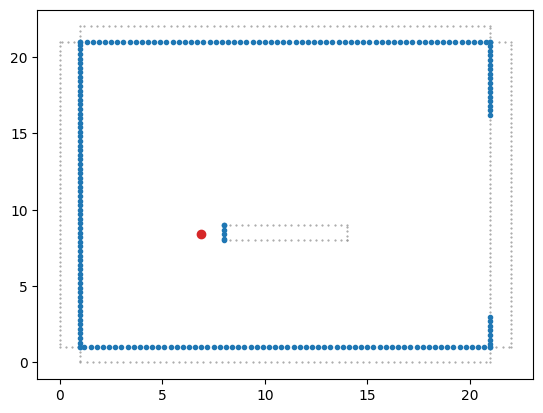

In [85]:
i = 1601

plt.plot(
    geometry.boundary.coords.x,
    geometry.boundary.coords.y,
    '.', color='#999', markersize=1
)

plt.plot(
    geometry.visible_plane.training_locations[i][0],
    geometry.visible_plane.training_locations[i][1],
    'o', color='tab:red'
)
plt.plot(
    geometry.visible_plane.coords.x[i],
    geometry.visible_plane.coords.y[i],
    '.'
)

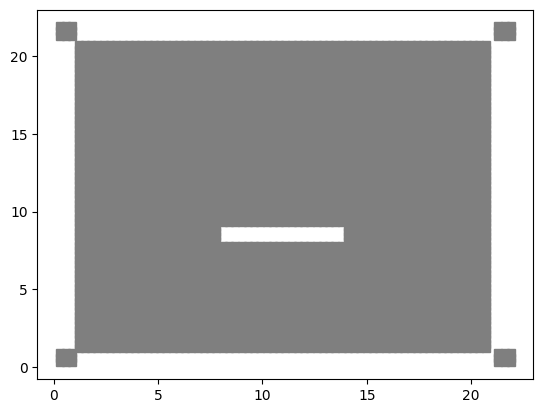

In [86]:
_ = geometry.training_space.plot()

## Process visible plane

In [ ]:
builder = EnvironmentBuilder.load('../cfg/envs/inserted_barrier.ini')

In [31]:
env = EnvironmentCompiler(builder).compile()

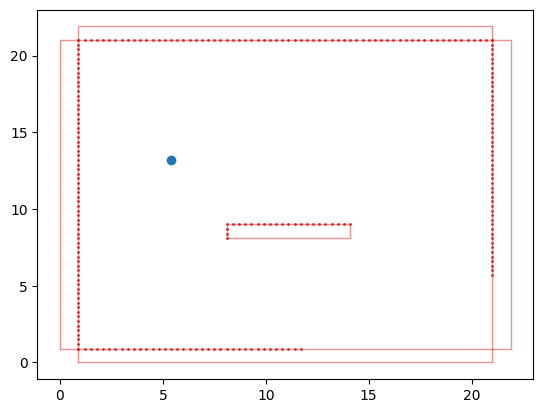

In [41]:
fig, ax = plt.subplots()
position = 1000
for i, obj in enumerate(env.objects):
    plot_polygon(obj.polygon, ax=ax, alpha=0.5, linewidth=1)
    ax.plot(
        obj.visible_parts[position, :, 0],
        obj.visible_parts[position, :, 1],
        'o',
        color='tab:red',
        markersize=1
    )

ax.plot(
    env.visible_area.points[position, 0],
    env.visible_area.points[position, 1],
    'o'
)
